In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import linregress


In [2]:
plt.rcParams['figure.figsize'] = (8, 4)

data_dir = Path(".")  

df_pumping=pd.read_csv("Pumping_test_data_Trumpletts Farm_2025-10-22_full.csv")
df_surveying=pd.read_csv("Surveying Field Sheet_2025-10-22(1).csv")
  

In [3]:
casing_elev = pd.Series(
    {
        "PL10A": 107.358,   # mAOD
        "PL10B": 110.102,
        "PL10E": 107.032,
        "BBA":  105.757,
    },
    name="casing_elev_mAOD"
)
print("\n" + "-"*70)
print("Casting Elevation (mAOD):")
for well, elev in casing_elev.items():
    print(f"  {well}: {elev:.3f}")
    


----------------------------------------------------------------------
Casting Elevation (mAOD):
  PL10A: 107.358
  PL10B: 110.102
  PL10E: 107.032
  BBA: 105.757


In [4]:
df = df_pumping.rename(columns={
    "Time_PL10A": "t_A",
    "Dip_m_A": "dip_A",

    "Time_PL10B": "t_B",
    "Dip_m_B": "dip_B",
    "Comments.1": "com_B",

    "Time_PL10E": "t_E",
    "Dip_m_E": "dip_E",
    "Comments.2": "com_E",

    "Time_BBA": "t_BBA",
    "Dip_m_BBA": "dip_BBA",
    "Comments.3": "com_BBA",

    "Time_BBA(logged)": "t_BBAlog",
    "Level_mAOD_logged": "head_BBAlog",

    "Time_BBA_Obs": "t_OBS",
    "Level_mAOD_Obs": "head_OBS"
})



In [5]:
from scipy.stats import zscore

def smoothness_check_z(df, dip_col, well_name):
    dip = df[dip_col].astype(float)
    d_dip = dip.diff()  # 一阶差分
    
    # z-score on non-NaN Δdip
    z = zscore(d_dip.dropna())
    z_full = pd.Series(np.nan, index=dip.index)
    z_full.loc[d_dip.dropna().index] = z
    
    # threshold: |z| > 3 → potential jump
    outlier = z_full.abs() > 3
    
    print(f"{well_name}: Δdip mean={d_dip.mean():.4f}, std={d_dip.std():.4f}")
    print(f"{well_name}: z>3 count = {outlier.sum()}")
    
    return d_dip, z_full, outlier

dA, zA, outA = smoothness_check_z(df, "dip_A", "PL10A")
dB, zB, outB = smoothness_check_z(df, "dip_B", "PL10B")
dE, zE, outE = smoothness_check_z(df, "dip_E", "PL10E")



PL10A: Δdip mean=0.0012, std=0.0263
PL10A: z>3 count = 4
PL10B: Δdip mean=0.0024, std=0.0614
PL10B: z>3 count = 1
PL10E: Δdip mean=0.0027, std=0.0456
PL10E: z>3 count = 2


In [6]:
#df_clean = df.drop(columns=["com_B", "com_E", "com_BBA"])
#df_clean.head()

In [7]:
#As wells were not recorded at the same time, so set them as three individual dataframe.
# Delete null values and edit on a copied column
df_A = df[["t_A", "dip_A"]].dropna(subset=["t_A", "dip_A"]).copy()
df_B = df[["t_B", "dip_B"]].dropna(subset=["t_B", "dip_B"]).copy()
df_E = df[["t_E", "dip_E"]].dropna(subset=["t_E", "dip_E"]).copy()


df_BBAlog = df[["t_BBAlog", "head_BBAlog"]].dropna().copy()
df_OBS    = df[["t_OBS", "head_OBS"]].dropna().copy()



In [8]:
# change as datetime format, 2025-10-22
df_A["datetime"] = pd.to_datetime("2025-10-22 " + df_A["t_A"].astype(str))
df_B["datetime"] = pd.to_datetime("2025-10-22 " + df_B["t_B"].astype(str))
df_E["datetime"] = pd.to_datetime("2025-10-22 " + df_E["t_E"].astype(str))

df_BBAlog["datetime"] = pd.to_datetime("2025-10-22 " + df_BBAlog["t_BBAlog"].astype(str))
df_OBS["datetime"]    = pd.to_datetime("2025-10-22 " + df_OBS["t_OBS"].astype(str))


df_A = df_A.set_index("datetime").sort_index()
df_B = df_B.set_index("datetime").sort_index()
df_E = df_E.set_index("datetime").sort_index()
df_BBAlog = df_BBAlog.set_index("datetime").sort_index()
df_OBS = df_OBS.set_index("datetime").sort_index()


pump_start = pd.to_datetime("2025-10-22 12:00:00")
pump_end   = pd.to_datetime("2025-10-22 14:00:00") 

In [9]:
#casing_A,casing_B, casing_E = 107.36, 110.10, 107.03

#casting elevation - dip depth, then convert data to float. Data now are all in mAOD, 
df_A["head"] = casing_elev["PL10A"] - df_A["dip_A"].astype(float)
df_B["head"] = casing_elev["PL10B"] - df_B["dip_B"].astype(float)
df_E["head"] = casing_elev["PL10E"] - df_E["dip_E"].astype(float)
df_OBS["head"] = df_OBS["head_OBS"].astype(float)


In [10]:
# the mean value before pumping
pre_A = df_A[df_A.index < pump_start]
pre_B = df_B[df_B.index < pump_start]
pre_E = df_E[df_E.index < pump_start]
pre_obs = df_OBS[df_OBS.index < pump_start]

 
h0_A = pre_A["head"].mean()
h0_B = pre_B["head"].mean()
h0_E = pre_E["head"].mean()
h0_obs = pre_obs["head"].mean()

In [11]:

df_A["s"] = h0_A - df_A["head"]
df_B["s"] = h0_B - df_B["head"]
df_E["s"] = h0_E - df_E["head"]


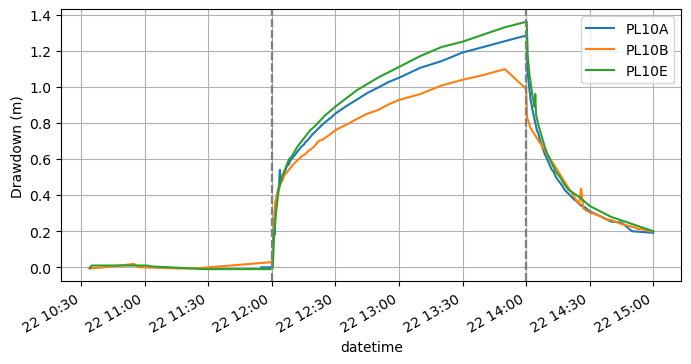

In [12]:

for lab, d in zip(["PL10A","PL10B","PL10E"], [df_A, df_B, df_E]):
    ax = d["s"].plot(label=lab)
    ax.axvline(pump_start, color="gray", linestyle="--")
    ax.axvline(pump_end,color="grey",linestyle="--")
plt.ylabel("Drawdown (m)")
plt.legend()
plt.grid(True)
plt.show()



In [13]:
coords = pd.DataFrame({
    "Easting": {
        "A": 451304.8,   
        "B": 451320.4,   
        "E": 451343.7,   
        "BBA": 451330.0
    },
    "Northing": {
        "A": 175029.6,
        "B": 175063.1,
        "E": 175044.1,
        "BBA": 175010.0
    }
})

coords["r_to_BBA"] = np.sqrt(
    (coords["Easting"] - coords.loc["BBA","Easting"])**2 +
    (coords["Northing"] - coords.loc["BBA","Northing"])**2
)

r_A = coords.loc["A","r_to_BBA"]
r_B = coords.loc["B","r_to_BBA"]
r_E = coords.loc["E","r_to_BBA"]

print("r_A, r_B, r_E =", r_A, r_B, r_E)


r_A, r_B, r_E = 31.924911902788626 53.96081911906241 36.74914965003566


In [14]:
Q = 0.058  # m3/s

def jacob_for_well(df_well, r, pump_start, pump_end,
                   t_min_after_start=600,   
                   t_max_before_end=None):  
    """
    df_well: 某一口井的 DataFrame，index = datetime，含 's' 列
    r: 到抽水井距离 [m]
    pump_start, pump_end: 抽水开始/结束时间
    t_min_after_start: Data is only used after how many seconds have passed since pumping started
    t_max_before_end: 距抽水开始的最大秒数；默认 = 抽水持续时间
    t_sec:How long has passed since the pumping started at each observation point?
    """
    t_sec = (df_well.index - pump_start).total_seconds()
    
    if t_max_before_end is None:
        t_max_before_end = (pump_end - pump_start).total_seconds()
    

    mask = (t_sec > t_min_after_start) & \
           (t_sec < t_max_before_end) & \
           (df_well["s"] > 0)
    
    t = t_sec[mask]
    s = df_well.loc[mask, "s"]
    

    if len(s) < 3:
        raise ValueError("Not enough late-time pumping points for this well.")
    
    logt = np.log10(t)
    slope, intercept, r_value, p_value, std_err = linregress(logt, s)
    
    T = (2.3 * Q) / (4 * np.pi * slope)
    logt0 = -intercept / slope
    t0 = 10**logt0
    S = (2.25 * T * t0) / (r**2)
    
    res = {
        "slope": slope,
        "intercept": intercept,
        "R2": r_value**2,
        "T_m2_per_s": T,
        "S": S,
        "t0_sec": t0
    }
    return res, logt, s



In [15]:
jac_A, logt_A, sA_late = jacob_for_well(df_A, r_A, pump_start, pump_end,
                                    t_min_after_start=600)
jac_B, logt_B, sB_late = jacob_for_well(df_B, r_B, pump_start, pump_end,
                                        t_min_after_start=600)
jac_E, logt_E, sE_late = jacob_for_well(df_E, r_E, pump_start, pump_end,
                                        t_min_after_start=600)

print("PL10A:",jac_A)
print("PL10B:", jac_B)
print("PL10E:", jac_E)


PL10A: {'slope': np.float64(0.6217777601220308), 'intercept': np.float64(-1.1511858285261678), 'R2': np.float64(0.992283857572117), 'T_m2_per_s': np.float64(0.01707303699982126), 'S': np.float64(0.0026771732548464084), 't0_sec': np.float64(71.03012731244546)}
PL10B: {'slope': np.float64(0.5207424200107958), 'intercept': np.float64(-0.92239928111799), 'R2': np.float64(0.9896048278940521), 'T_m2_per_s': np.float64(0.020385577007552676), 'S': np.float64(0.0009303883608338242), 't0_sec': np.float64(59.06304173172314)}
PL10E: {'slope': np.float64(0.6832786824278079), 'intercept': np.float64(-1.3113139791684216), 'R2': np.float64(0.9924293244654319), 'T_m2_per_s': np.float64(0.015536317723992535), 'S': np.float64(0.002148748460382556), 't0_sec': np.float64(83.0136586287993)}


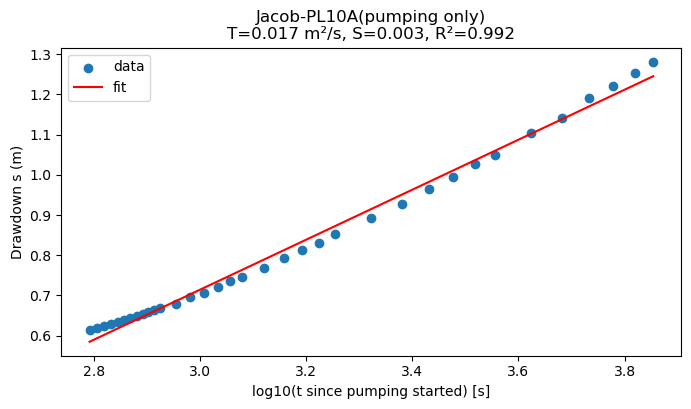

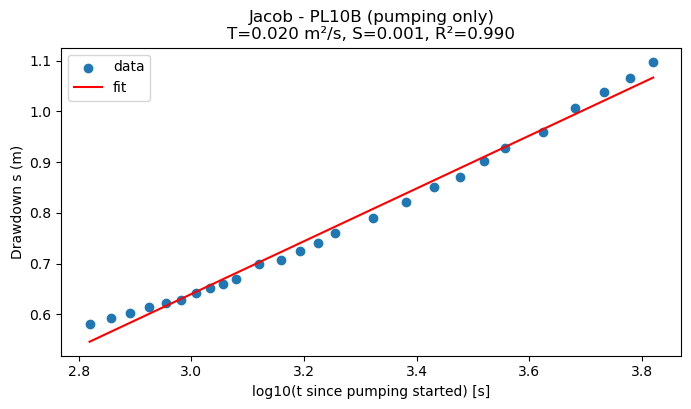

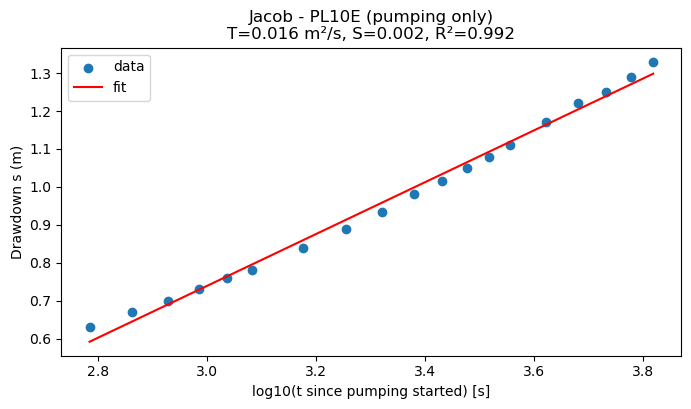

In [16]:
def plot_jacob(logt,s_late,jac_res, title):
    m = jac_res["slope"]
    c = jac_res["intercept"]
    
    fig, ax = plt.subplots()
    ax.scatter(logt, s_late, label="data")
    ax.plot(logt, m*logt + c, color="r", label="fit")
    ax.set_xlabel("log10(t since pumping started) [s]")
    ax.set_ylabel("Drawdown s (m)")
    ax.set_title(
        f"{title}\nT={jac_res['T_m2_per_s']:.3f} m²/s, "
        f"S={jac_res['S']:.3f}, R²={jac_res['R2']:.3f}"
    )
    ax.legend()
    plt.show()

plot_jacob(logt_A,sA_late,jac_A,"Jacob-PL10A(pumping only)")
plot_jacob(logt_B, sB_late, jac_B, "Jacob - PL10B (pumping only)")
plot_jacob(logt_E, sE_late, jac_E, "Jacob - PL10E (pumping only)")


In [17]:
T_A_m2s = 0.017
T_B_m2s = 0.020
T_E_m2s = 0.016

# change to m²/day
T_A = T_A_m2s * 86400
T_B = T_B_m2s * 86400
T_E = T_E_m2s * 86400
T_mean= np.mean([T_A,T_B,T_E])

print(f"T_A = {T_A:.3f} m/day")
print(f"T_B = {T_B:.3f} m/day")
print(f"T_E = {T_E:.3f} m/day")
print(f"T_mean = {T_mean:.3f} m/day")



T_A = 1468.800 m/day
T_B = 1728.000 m/day
T_E = 1382.400 m/day
T_mean = 1526.400 m/day


# Using hydraulic gradient (i) to calculate Darcy's velocity

In [18]:
#h=Ax(easting)+By(northing)+C
X = np.array([451304.8, 451320.4, 451343.7, 451365.0])
Y = np.array([175029.6, 175063.1, 175044.1, 174834.0])

H = np.array([h0_A, h0_B, h0_E, h0_obs])


In [19]:
M = np.column_stack((X, Y, np.ones(len(X))))
ABC, *_ = np.linalg.lstsq(M, H, rcond=None)
A, B, C = ABC


i = np.sqrt(A**2 + B**2)

theta_rad = np.arctan2(B,A)
gradient_angle_geo = np.degrees(theta_rad)
flow_angle_geo = gradient_angle_geo + 180


print(f"A = {A:.3}")
print(f"B ={B:.3f}")
print(f"C = {C:.3f}")
print("Gradient i =", i)
print(f"Gradient direction = {gradient_angle_geo:.2f}°")
print(f"Flow direction = {flow_angle_geo:.3f}°, 0° is taken as East and angles increase counter-clockwise")


A = -0.00157
B =-0.003
C = 1287.924
Gradient i = 0.003225929666052003
Gradient direction = -119.11°
Flow direction = 60.890°, 0° is taken as East and angles increase counter-clockwise


In [20]:
aquifer_base=29
K=T_mean/aquifer_base
q=K*i
Q = T_mean * i     
print(f"hydraulic conductivity K = {K:.3f} m/day")
print(f"darcy velocity q = {q:.3f} m/day")
print(f"flow per unit width Q' = {Q:.3f} m²/day")

hydraulic conductivity K = 52.634 m/day
darcy velocity q = 0.170 m/day
flow per unit width Q' = 4.924 m²/day


# Seepage Velocity

In [21]:
n = 0.30   # assumed site is composed of sand and gravel, effective porosity values for sandy–gravel aquifers range between 0.25 and 0.35
v = q / n
print(f"Seepage velocity v = {v:.2f} m/day")

Seepage velocity v = 0.57 m/day


# Jacob Recovery  

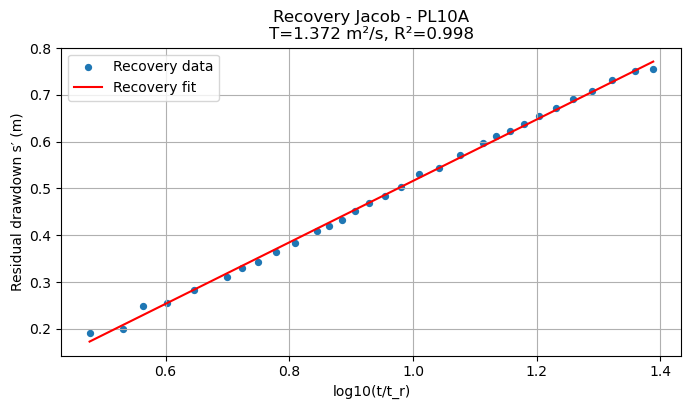

PL10A: T = 1.372 m²/s, R² = 0.998


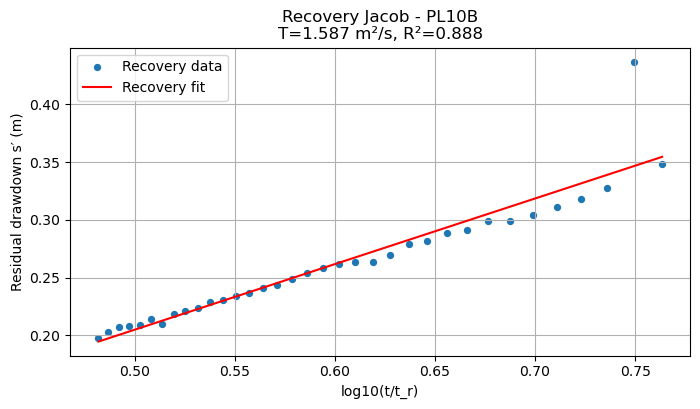

PL10B: T = 1.587 m²/s, R² = 0.888


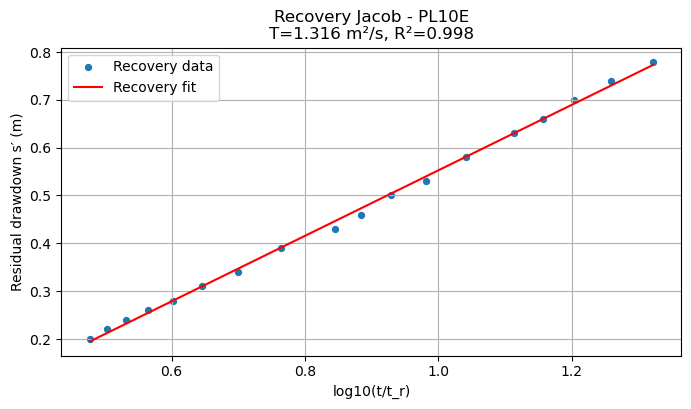

PL10E: T = 1.316 m²/s, R² = 0.998


In [28]:

def jacob_recovery(df, pump_start, pump_end, Q, well_name):
    t = (df.index - pump_start).total_seconds()
    tr = (df.index - pump_end).total_seconds()

    mask = (tr > 300) & (df["s"] > 0)
    t = t[mask]
    tr = tr[mask]
    s = df["s"][mask]

    X = np.log10(t / tr)
    Y = s.values

    slope, intercept, r, p, stderr = linregress(X, Y)
    T_rec = (2.3 * Q) / (4 * np.pi * slope)

    plt.scatter(X, Y, label="Recovery data", s=18)
    plt.plot(X, slope * X + intercept, 'r', label="Recovery fit")
    plt.xlabel("log10(t/t_r)")
    plt.ylabel("Residual drawdown s′ (m)")
    plt.title(f"Recovery Jacob - {well_name}\nT={T_rec:.3f} m²/s, R²={r**2:.3f}")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"{well_name}: T = {T_rec:.3f} m²/s, R² = {r**2:.3f}")
    return T_rec, r**2

#For three wells
for df, name in zip([df_A, df_B, df_E], ["PL10A", "PL10B", "PL10E"]):
    jacob_recovery(df, pump_start, pump_end, Q, name)


# Thies # 

In [29]:
pump_start = pd.to_datetime("2025-10-22 12:00:00")
pump_end   = pd.to_datetime("2025-10-22 14:00:00")  
Q = 0.058  # m3/s

r_A, r_B, r_E = 31.9249, 53.9608, 36.7491  


PL10A Theis fit:
  T = 0.021 m²/s
  S = 0.001 [-]
  R² = 0.972


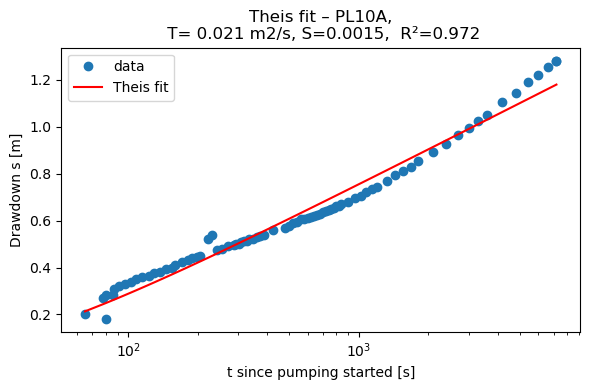

PL10B Theis fit:
  T = 0.026 m²/s
  S = 0.000 [-]
  R² = 0.963


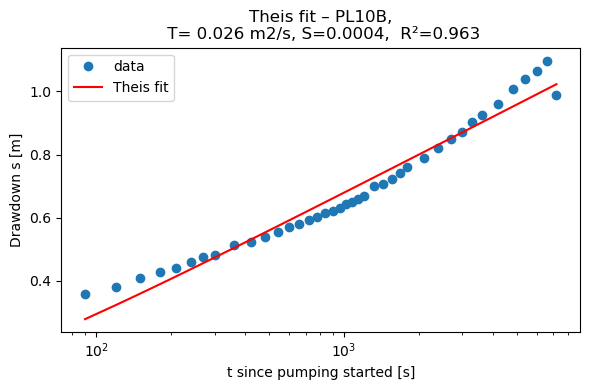

PL10E Theis fit:
  T = 0.018 m²/s
  S = 0.001 [-]
  R² = 0.990


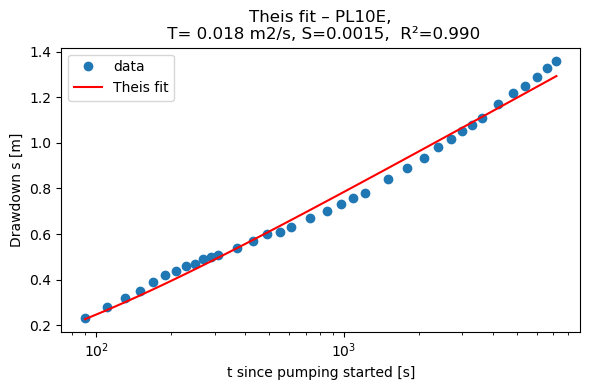

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expi
from scipy.optimize import curve_fit


def theis_drawdown(t, T, S, Q, r):

    t = np.asarray(t, dtype=float)

    t[t <= 0] = np.nan
    u = r**2 * S / (4 * T * t)
    W = -expi(-u)         
    s = (Q / (4 * np.pi * T)) * W
    return s


def fit_theis_for_well(df, r, Q, label, t_min_cut=60):

    mask = (df.index >= pump_start) & (df.index <= pump_end)
    df_pump = df.loc[mask].copy()


    t = (df_pump.index - pump_start).total_seconds().values
    s_obs = df_pump["s"].values

    # remove realy point
    sel = t > t_min_cut
    t_fit = t[sel]
    s_fit = s_obs[sel]


    p0 = [0.02, 1e-3]
    bounds = ([1e-4, 1e-6], [1.0, 1e-1])


    def model(t, T, S):
        return theis_drawdown(t, T, S, Q=Q, r=r)

    popt, pcov = curve_fit(model, t_fit, s_fit, p0=p0, bounds=bounds)
    T_est, S_est = popt


    s_theis = model(t_fit, T_est, S_est)


    ss_res = np.sum((s_fit - s_theis)**2)
    ss_tot = np.sum((s_fit - s_fit.mean())**2)
    R2 = 1 - ss_res/ss_tot

    print(f"{label} Theis fit:")
    print(f"  T = {T_est:.3f} m²/s")
    print(f"  S = {S_est:.3f} [-]")
    print(f"  R² = {R2:.3f}")


    plt.figure(figsize=(6,4))
    plt.semilogx(t_fit, s_fit, "o", label="data")
    plt.semilogx(t_fit, s_theis, "-", label="Theis fit", color="red")
    plt.xlabel("t since pumping started [s]")
    plt.ylabel("Drawdown s [m]")
    plt.title(f"Theis fit – {label},\n T= {T_est:.3f} m2/s, S={S_est:.4f},  R²={R2:.3f}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return T_est, S_est, R2


T_A, S_A, R2_A = fit_theis_for_well(df_A, r_A, Q, label="PL10A", t_min_cut=60)
T_B, S_B, R2_B = fit_theis_for_well(df_B, r_B, Q, label="PL10B", t_min_cut=60)
T_E, S_E, R2_E = fit_theis_for_well(df_E, r_E, Q, label="PL10E", t_min_cut=60)


# Drawdown-Distance 


In [32]:
time_to_plot = pd.to_datetime("2025-10-22 13:00:00")

sA = df_A.loc[time_to_plot, "s"]
sB = df_B.loc[time_to_plot, "s"]
sE = df_E.loc[time_to_plot, "s"]


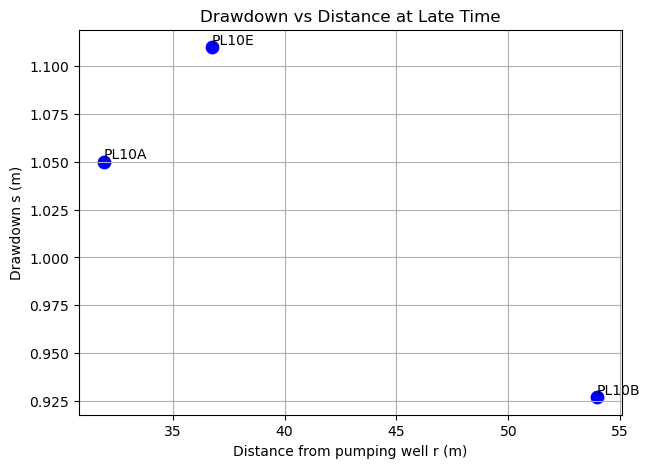

In [33]:
r_A = 31.9249 
r_B = 53.9608 
r_E = 36.7491 

r = [r_A, r_B, r_E]
s = [sA, sB, sE]

plt.figure(figsize=(7,5))
plt.scatter(r, s, s=80, color="blue")

for ri, si, lab in zip(r, s, ["PL10A","PL10B","PL10E"]):
    plt.text(ri, si, lab, fontsize=10, ha='left', va='bottom')

plt.xlabel("Distance from pumping well r (m)")
plt.ylabel("Drawdown s (m)")
plt.title("Drawdown vs Distance at Late Time")
plt.grid(True)
plt.show()

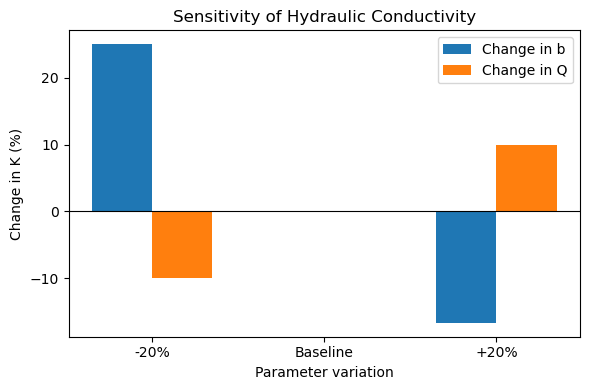

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


T_base = 0.020      
b_base = 29         
Q_base = 0.058     
i_base = 0.00322    
n_base = 0.25       


b_var = np.array([0.8, 1.0, 1.2])   
Q_var = np.array([0.9, 1.0, 1.1])    

def calc_K(T, b): return T / b
def calc_q(K, i): return K * i

K_base = calc_K(T_base, b_base)
q_base = calc_q(K_base, i_base)


K_b = calc_K(T_base, b_base * b_var)
K_Q = calc_K(T_base * Q_var, b_base)


change_K_b = 100 * (K_b - K_base) / K_base
change_K_Q = 100 * (K_Q - K_base) / K_base


labels = ['-20%', 'Baseline', '+20%']
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(x - width/2, change_K_b, width, label='Change in b')
ax.bar(x + width/2, change_K_Q, width, label='Change in Q')
ax.axhline(0, color='k', linewidth=0.8)

ax.set_ylabel('Change in K (%)')
ax.set_xlabel('Parameter variation')
ax.set_title('Sensitivity of Hydraulic Conductivity')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.tight_layout()
plt.show()
